<a href="https://colab.research.google.com/github/JuanVictorPM/Analise-de-dados-Sales-Management/blob/master/Pr%C3%A1tica_1_Gerador_de_n%C3%BAmeros_aleat%C3%B3rios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

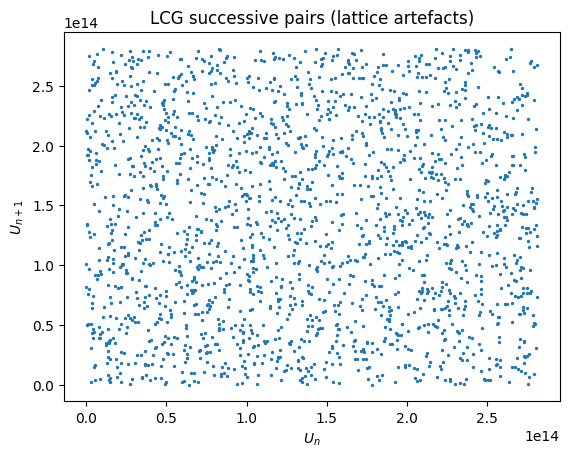

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class LCG:
    def __init__(self, seed=25):
        self.m = 2**48
        self.a = 25214903917
        self.c = 11
        self.x = seed % self.m
    def random(self):
        self.x = (self.a * self.x + self.c) % self.m
        return self.x
    def random_array(self, n):
        out = np.empty(n)
        for i in range(n):
            out[i] = self.random()
        return out

# Visualize lattice artefacts via successive pairs
rng = LCG(42)
U = rng.random_array(2000)
plt.figure()
plt.scatter(U[:-1], U[1:], s=2, alpha=1)
plt.xlabel(r"$U_n$")
plt.ylabel(r"$U_{n+1}$")
plt.title("LCG successive pairs (lattice artefacts)")
plt.show()



In [2]:
import numpy as np
from math import sqrt


def chisq_uniform(u, m=100):
  """Chi-square test for U(0,1) in m equal bins. Returns (statistic, p)."""
  n = len(u)
  counts, _ = np.histogram(u, bins=m)
  expected = n / m
  stat = ((counts - expected)**2 / expected).sum()
  # Prefer SciPy if present
  try:
    from scipy.stats import chi2
    p = chi2.sf(stat, df=m-1)
  except Exception:
    # Wilson–Hilferty approximation
    k = m - 1
    z = ((stat/k)**(1/3) - (1 - 2/(9*k))) / sqrt(2/(9*k))
    from math import erf
    p = 0.5 * (1 - erf(z / sqrt(2)))
  return stat, p


def ks_uniform(u):
  """KS test for U(0,1). Returns (D, p) using SciPy or asymptotic fallback."""
  n = len(u)
  x = np.sort(u)
  D_plus = np.max(np.arange(1, n+1)/n - x)
  D_minus = np.max(x - np.arange(0, n)/n)
  D = max(D_plus, D_minus)
  try:
    from scipy.stats import kstest
    _, p = kstest(u, 'uniform')
  except Exception:
    from math import exp
    t = (sqrt(n) + 0.12 + 0.11/sqrt(n)) * D
    p = 2 * sum(((-1)**(k-1)) * exp(-2*(k**2)*(t**2)) for k in range(1, 100))
    p = max(min(p, 1.0), 0.0)
  return D, p

In [3]:
x2, p = chisq_uniform(U)
print(x2)
print(p)

D, p = ks_uniform(U/2**48)
print(D)
print(p)

108.30000000000001
0.24562166423050463
0.022945756176709242
0.23932944066995


In [4]:
import numpy as np
import math
def autocorrelacao(u, lag=1):
  corr = np.corrcoef(u[:-lag], u[lag:])[0,1]
  return corr

In [5]:
cor = autocorrelacao(U,3)
print(cor)

-0.04904914222254769


# Exercícios

1. Elabore um gerador do tipo xorshift e faça o gráfico de dispersão dele para n=2000 exemplos. (40%)

2. Elabore uma função que faz um gráfico de dispersão das distâncias entre os valores passados como entrada. (20%)

3. Utilize a classe LCG para gerar diferentes geradores de números aleatórios entre 0 e 255. Qual a melhor parametrização que você encontrou? Justifique a partir de métricas de aleatoriedade (período, uniformidade, teste χ^2, autocorrelação, ...) (40%)


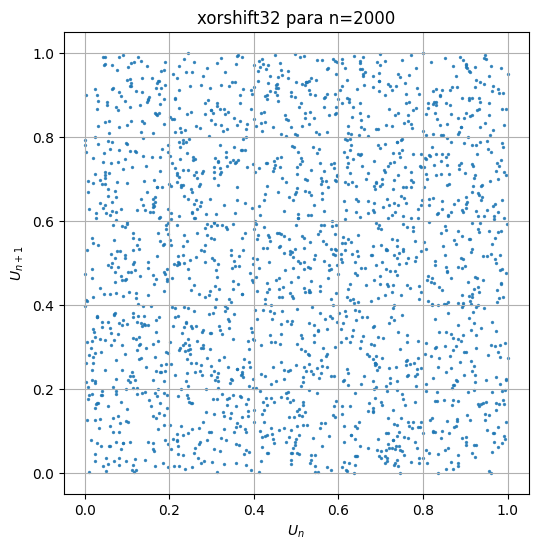

In [6]:
# Questão 1
class XorShift32:
    def __init__(self, seed=2463534242):
        self.x = seed & 0xFFFFFFFF
        if self.x == 0:
            self.x = 0xFFFFFFFF
    def random_uint32(self):
        self.x ^= (self.x << 13) & 0xFFFFFFFF
        self.x ^= (self.x >> 17) & 0xFFFFFFFF
        self.x ^= (self.x << 5) & 0xFFFFFFFF
        return self.x & 0xFFFFFFFF
    def random(self):
        return self.random_uint32() / 0x100000000  # normalize to [0,1)

rng_xs = XorShift32(seed=123456789)
N = 2000
U_xs = [rng_xs.random() for _ in range(N)]

plt.figure(figsize=(6,6))
plt.scatter(U_xs[:-1], U_xs[1:], s=2, alpha=0.8)
plt.xlabel(r"$U_n$")
plt.ylabel(r"$U_{n+1}$")
plt.title("xorshift32 para n=2000")
plt.grid(True)
plt.show()

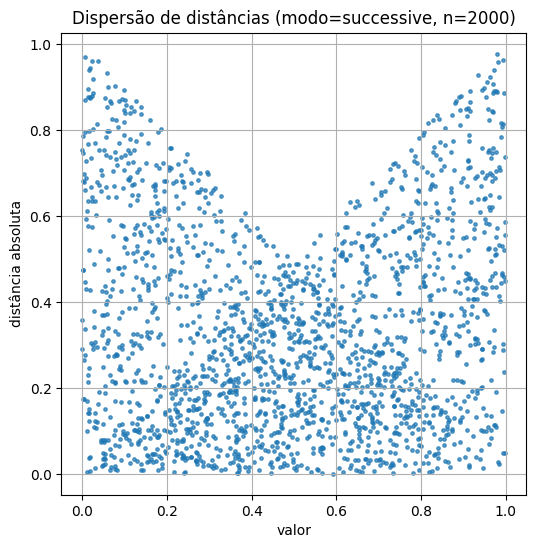

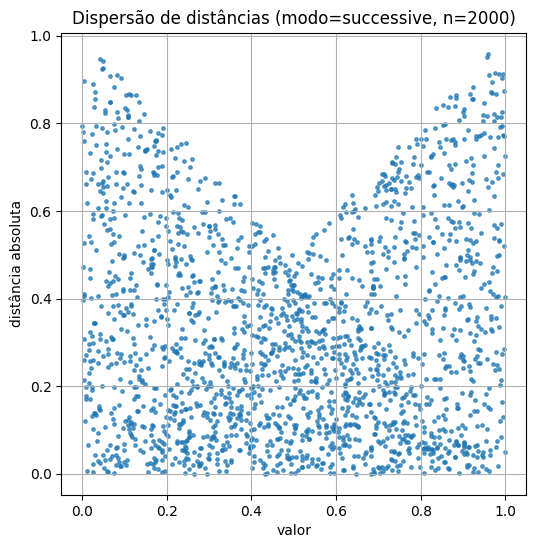

In [7]:
# Questão 2: função que plota dispersão das distâncias entre valores

def scatter_distances(values, mode='successive', sample_pairs=50000, max_points=2000):
    v = np.asarray(values)
    n = len(v)
    if n < 2:
        raise ValueError("Necessário pelo menos 2 valores para calcular distâncias")

    if mode == 'successive':
        x = v[:-1]
        y = np.abs(v[1:] - v[:-1])
    elif mode == 'pairwise':
        # amostrar pares aleatórios
        max_pairs = min(sample_pairs, n*(n-1)//2)
        # se n grande e max_pairs pequeno, amostramos índices com reposição até obter max_pairs
        if max_pairs == n*(n-1)//2:
            i_idx, j_idx = np.triu_indices(n, k=1)
            if len(i_idx) > sample_pairs:
                sel = np.random.choice(len(i_idx), size=sample_pairs, replace=False)
                i_idx = i_idx[sel]
                j_idx = j_idx[sel]
        else:
            i_idx = np.random.randint(0, n, size=max_pairs)
            j_idx = np.random.randint(0, n, size=max_pairs)
            neq = i_idx != j_idx
            i_idx = i_idx[neq]
            j_idx = j_idx[neq]
        x = v[i_idx]
        y = np.abs(v[j_idx] - v[i_idx])
    else:
        raise ValueError("mode deve ser 'successive' ou 'pairwise'")

    # limitar pontos para plotagem
    if len(x) > max_points:
        sel = np.random.choice(len(x), size=max_points, replace=False)
        x = x[sel]
        y = y[sel]

    plt.figure(figsize=(6,6))
    plt.scatter(x, y, s=6, alpha=0.7)
    plt.xlabel('valor')
    plt.ylabel('distância absoluta')
    plt.title(f"Dispersão de distâncias (modo={mode}, n={n})")
    plt.grid(True)
    plt.show()

# Exemplos usando os parametros anteriores
try:
    scatter_distances(U/2**48, mode='successive', max_points=2000)
except Exception as e:
    print('Erro usando U do LCG (talvez a célula anterior não tenha sido executada):', e)

try:
    scatter_distances(U_xs, mode='successive', max_points=2000)
except Exception as e:
    print('Erro usando U_xs do xorshift (talvez a célula anterior não tenha sido executada):', e)

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Top 10 parametrizações (a, c) para m=256:
a=  5, c=211, period=256, len_seq=256, chi2_p=1.0, autocorr=0.02819128665497668
a=  5, c= 97, period=256, len_seq=256, chi2_p=1.0, autocorr=-0.08012335987288785
a=  5, c=121, period=256, len_seq=256, chi2_p=1.0, autocorr=-0.08993513106436056
a=  5, c= 31, period=256, len_seq=256, chi2_p=1.0, autocorr=0.09157009692760586
a=  1, c=211, period=256, len_seq=256, chi2_p=1.0, autocorr=0.12430168721336995
a=  5, c= 17, period=256, len_seq=256, chi2_p=1.0, autocorr=0.13702242902117046
a=  5, c= 13, period=256, len_seq=256, chi2_p=1.0, autocorr=0.1584486108419267
a=  5, c= 11, period=256, len_seq=256, chi2_p=1.0, autocorr=0.1727340185156868
a=  5, c=  5, period=256, len_seq=256, chi2_p=1.0, autocorr=0.17564350440014836
a=  5, c=  1, period=256, len_seq=256, chi2_p=1.0, autocorr=0.19535020146866855

Melhor candidato explicado: a=5, c=211, period=256


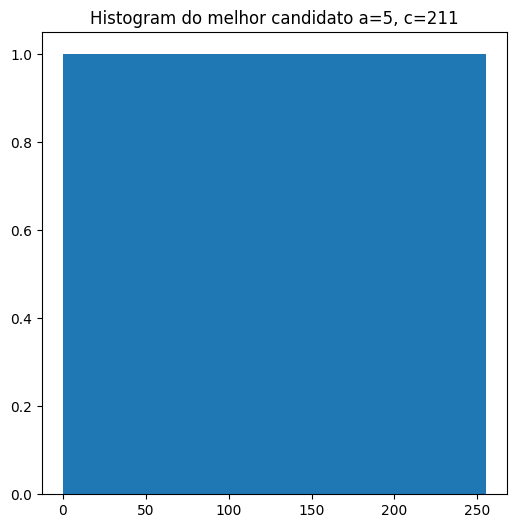

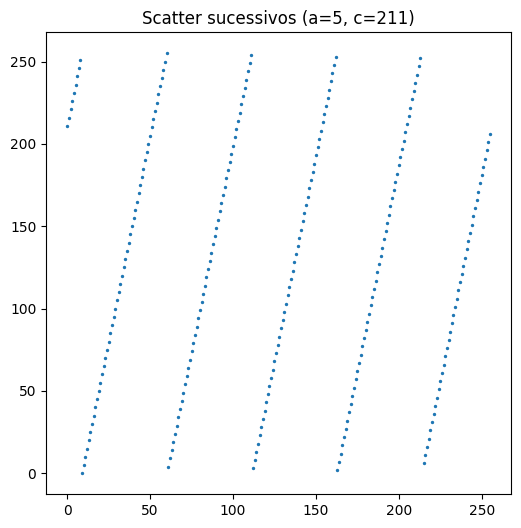

In [8]:
# Questão 3: testar parametrizações da LCG para gerar números em 0..255
from collections import defaultdict
from scipy.stats import chi2

def lcg_bytes(a, c, seed=1, m=256, max_steps=1000):
    x = seed % m
    seen = {}
    seq = []
    for i in range(max_steps):
        if x in seen:
            period = i - seen[x]
            return seq, period
        seen[x] = i
        seq.append(x)
        x = (a * x + c) % m

    return seq, None


def evaluate_lcg_params(params, n_samples=2000):
    """Avalia uma lista de (a,c) tuplas e retorna métricas: period, chi2 p-value, autocorr"""
    results = []
    for a, c in params:
        seq, period = lcg_bytes(a, c, seed=1, m=256, max_steps=10000)
        arr = np.array(seq[:n_samples]) if len(seq) >= 2 else np.array(seq)
        # chi2 test
        try:

            counts = np.bincount(arr, minlength=256)
            expected = len(arr) / 256
            stat = ((counts - expected)**2 / expected).sum()
            p = chi2.sf(stat, df=255)
        except Exception:
            # fallback simples: compute stat but not p accurately
            counts = np.bincount(arr, minlength=256)
            expected = len(arr) / 256
            stat = ((counts - expected)**2 / expected).sum()
            p = None
        # autocorrelation lag 1 (normalize arr to [0,1] for this metric)
        if len(arr) > 1:
            u = arr / 255.0
            autocorr = np.corrcoef(u[:-1], u[1:])[0,1]
        else:
            autocorr = None
        results.append({
            'a': a, 'c': c, 'period': period or 0, 'chi2_stat': stat, 'chi2_p': p, 'autocorr': autocorr, 'len_seq': len(seq)
        })
    return results

# construir params candidatos: a em [1, 255], c em [1,255], filtrar alguns triviais
params = [(a, c) for a in range(1, 256) for c in [1,3,5,11,13,17,31,97,121,211]]
results = evaluate_lcg_params(params, n_samples=2000)

# heurística para ordenação: preferir maior period, maior p, autocorr próximo a 0
def score(r):
    s = r['period']
    if r['chi2_p'] is not None:
        s += (r['chi2_p'] * 1000)
    if r['autocorr'] is not None:
        s -= abs(r['autocorr']) * 100
    return s

results_sorted = sorted(results, key=score, reverse=True)

# Mostrar os top 10 candidatos
print('Top 10 parametrizações (a, c) para m=256:')
for r in results_sorted[:10]:
    print(f"a={r['a']:3d}, c={r['c']:3d}, period={r['period']:3d}, len_seq={r['len_seq']:3d}, chi2_p={r['chi2_p']}, autocorr={r['autocorr']}")

# Mostrar sequência e histograma do melhor candidato
best = results_sorted[0]
seq, period = lcg_bytes(best['a'], best['c'], seed=1, m=256, max_steps=10000)
arr = np.array(seq)
print('\nMelhor candidato explicado: a={a}, c={c}, period={p}'.format(a=best['a'], c=best['c'], p=best['period']))

plt.figure(figsize=(6,6))
plt.title(f"Histogram do melhor candidato a={best['a']}, c={best['c']}")
plt.hist(arr, bins=256)
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(arr[:-1], arr[1:], s=2)
plt.title(f"Scatter sucessivos (a={best['a']}, c={best['c']})")
plt.show()